# ISOM5160 Project - Group7

- **Dataset:** amazon_food_reviews.csv
- **Topic:** AI Driven Personalized Product Improvement Recommendation System for Amazon Sellers
- **Individual Contribution:**

    | Name          | SID      | Contributions                                                                                                          |
    |---------------|----------|------------------------------------------------------------------------------------------------------------------------|
    | CAO, Xi       | 21271664 | 评论文本预处理 + 情感分析 + 评论关键词提取 +数据清洗                                                                                                 |
    | LI, Heyi      |          | 评论、评分异常值分析 （基于评论情感分析）、 PPT 统筹                                                                                          |
    | LIAO, Jingyu  | 21262106 | 差评原因分析   （基于评论关键词）                                                                                                     |
    | LIN, Chuwei   |          | 评分时间趋势分析                                                                                                               |
    | YE, Chenwei   | 21199517 | 用户评论权重分析                                                                                                               |
    | ZHANG, Ziyang | 21266920 | 1. Data scraping: additional amazon product info <br/>2. Analyse: Correlation Between Ratings and Product Descriptions |



## 0. Install requirements and do initialization
1. Install requirements and load 'amazon_food_reviews.csv'
2. Scrape product info from *amazon.com*
3. Load product info and concat to original dataset

In [91]:
# Run first to install requirements
!pip install -r requirements.txt

# Run this to speed up the data scraping process
!unzip -oq new_data.zip

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

from amazon_new_data_scraping import parallel_scrape_amazon_product_info, load_all_data_as_dataframe, \
    extract_comments_from_product_info

df_amazon_food_reviews = pd.read_csv('amazon_food_reviews.csv',
                                     converters={"Time": lambda x: pd.to_datetime(int(x), unit="s")})

In [2]:
product_id_list = list(df_amazon_food_reviews.ProductId.unique())
print(f"Total number of products: {len(product_id_list)}")
print("Start scraping data...")
parallel_scrape_amazon_product_info(product_id_list, replace=False)
print("Scraping finished.")
df_amazon_product_info = load_all_data_as_dataframe()
print("Product info loaded.")
df_amazon_product_info

Total number of products: 4322
Start scraping data...
Using 12 CPU cores for parallel scraping


Scraping amazon products: 100%|██████████| 4322/4322 [00:00<00:00, 4615.33it/s]


Successfully scraped 4322/4322 products
Scraping finished.


Loading product info: 100%|██████████| 4322/4322 [00:00<00:00, 9759.89it/s]


Product info loaded.


,product_id,product_title,byline_info,product_description,category,alt_images,product_detail,important_information,top_comments,CountAltImages,Score,ScoreDistribution,ScorePolarizationIndex,NumRatings,IsFood
0,B0007GFDP4,Korean Seaweed 0.17oz5gea-4 Packs,Brand: JN,Freshness Guaranteed Premium Seaweed Winter Ha...,"[Grocery & Gourmet Food, Pantry Staples, Cooki...",[https://m.media-amazon.com/images/I/51uDkERYg...,{'Product Dimensions': '6.1 x 3.35 x 2.3 inche...,{'Ingredients': 'Seaweed. non gmo com oil. non...,"[{'date': 'March 22, 2013', 'title': 'Best Tas...",4,3.8,"[20.0, 0.0, 19.0, 0.0, 61.0]",0.483701,6,True
1,B000EMEEHE,GIN GINS Original Ginger Chews by The Ginger P...,Visit the The Ginger People Store,Deliciously spicy-sweet chewy ginger candies m...,"[Grocery & Gourmet Food, Snacks & Sweets, Cand...",[https://m.media-amazon.com/images/I/41KQy5H4V...,"{'Is Discontinued By Manufacturer': 'No', 'Pro...",{'Safety Information': 'Made in a facility tha...,"[{'date': 'July 9, 2014', 'title': 'Truly Life...",7,3.2,"[23.0, 9.0, 27.0, 9.0, 32.0]",0.281807,62,True
2,B000E671W0,"Celestial Seasonings Peppermint Herbal Tea, Ca...",Visit the Celestial Seasonings Store,Nothing is more soothing than a cup of your fa...,"[Grocery & Gourmet Food, Beverages, Tea, Fruit...",[https://m.media-amazon.com/images/I/61iWD7RnS...,"{'Is Discontinued By Manufacturer': 'No', 'Pro...",{'Safety Information': 'This product is labell...,"[{'date': 'August 3, 2025', 'title': 'DELICIOU...",6,4.8,"[2.0, 1.0, 2.0, 7.0, 88.0]",0.166892,37825,True
3,B000084E76,"Kookamunga Krazee Kitty Catnip Bubbles, 5 oz",Visit the KOOKAMUNGA Store,Make your cats go wild with this fun product. ...,"[Pet Supplies, Cats, Toys, Catnip Toys]",[https://m.media-amazon.com/images/I/4124SxrG1...,"{'Is Discontinued By Manufacturer': 'No', 'Pro...",{},"[{'date': 'July 17, 2015', 'title': 'My cat is...",3,3.2,"[26.0, 12.0, 12.0, 13.0, 37.0]",0.319141,728,False
4,B0009TQC90,Golden Dragon - Finest Chrysanthemum Pu Erh Te...,Brand: Golden Dragon,a specially selected of buds and young leaves ...,"[Grocery & Gourmet Food, Beverages, Tea, Black]",[https://m.media-amazon.com/images/I/51hGQNcQz...,"{'Is Discontinued By Manufacturer': 'No', 'Pac...",{'Legal Disclaimer': 'Statements regarding die...,"[{'date': 'January 7, 2012', 'title': 'Not exa...",7,3.2,"[10.0, 20.0, 32.0, 10.0, 28.0]",0.224108,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3376,B0006VB3WC,Katz-n-Flocken All Life Stages Cat Food - 15 lbs,Visit the Solid Gold Store,"Ideal for adult cats and kittens, to maintain ...","[Pet Supplies, Cats, Food]",[https://m.media-amazon.com/images/I/517dkgAGm...,"{'Is Discontinued By Manufacturer': 'No', 'Pro...",{},"[{'date': 'November 25, 2011', 'title': 'Katz-...",5,4.4,"[9.0, 0.0, 14.0, 0.0, 77.0]",0.382746,23,True
3377,B0001PB99K,Maker's Mark Bourbon Flavored Gourmet Cherries...,,,"[Grocery & Gourmet Food, Pantry Staples, Canne...",[https://m.media-amazon.com/images/I/31CDQM754...,"{'Is Discontinued By Manufacturer': 'No', 'UPC...",{'Legal Disclaimer': 'Statements regarding die...,[],1,4.0,"[0.0, 0.0, 0.0, 100.0, 0.0]",0.000000,1,True
3378,B000EDDSES,"Bob's Red Mill Old Country Style Muesli, 18oz ...",Visit the Bob's Red Mill Store,Product Description Old Country Style Muesli...,"[Grocery & Gourmet Food, Breakfast Cereal, Mue...",[https://m.media-amazon.com/images/I/411xsw6he...,"{'Is Discontinued By Manufacturer': 'No', 'Pro...","{'Ingredients': 'Whole Grain Wheat, Dates, Sun...","[{'date': 'October 17, 2011', 'title': 'I Love...",7,4.8,"[1.0, 1.0, 3.0, 8.0, 87.0]",0.156042,5058,True
3379,B00004RBDW,TERRO T380 Outdoor Reusable Fly Magnet Fly Tra...,Visit the Terro Store,Flies are an ever-present nuisance around home...,"[Patio, Lawn & Garden, Pest Control, Traps]",[https://m.media-amazon.com/images/I/41ecsqa4Z...,{},{},"[{'date': 'July 22, 2025', 'title': 'It works!...",7,4.2,"[9.0, 4.0, 9.0, 13.0, 65.0]",0.323871,-1,False


In [3]:
# Concat new reviews to the original dataset and drop duplicates
df_amazon_food_reviews = pd.concat([df_amazon_food_reviews, extract_comments_from_product_info(df_amazon_product_info)]
                                   ).drop_duplicates(['Score', 'Time', 'Summary']).reset_index(drop=True)
df_amazon_food_reviews

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,350.0,B00067AD4U,A2LYOWC3FC73XK,"Michael Ekstrum """"expresso bean fan""""",1,1.0,5,2007-05-12,excellent - exactly what I expected,The product was exactly as advertised and fres...
1,439.0,B000G6RYNE,A926YP1BSD72Y,Shopper11,0,0.0,5,2011-11-20,Best gluten-free dairy-free chips,These are my favorite gluten-free dairy-free f...
2,446.0,B000G6RYNE,A19G8B2QYETD7W,NyahNyah,0,0.0,3,2011-02-13,Heavy on the Vinegar,"I usually love Kettle Chips, and love salt & v..."
3,448.0,B000G6RYNE,ACFPHOYVB71V4,karob,0,0.0,5,2010-12-18,BEST BUY in BBQ Chips,Tried many varieties of BBQ chips and hands do...
4,452.0,B000G6RYNE,A2MUGFV2TDQ47K,"Lynrie """"Oh HELL no""""",0,0.0,3,2010-11-05,An Acquired Taste,"OK,I did read the reviews which ranged from sp..."
...,...,...,...,...,...,...,...,...,...,...
29960,NaN,B00004RBDW,NaN,NaN,1,NaN,4,2025-09-01,Awesome fly killer,"This thing works like a charm, it really does ..."
29961,NaN,B00004RBDW,NaN,NaN,6,NaN,5,2025-08-05,Put this item 40 feet away from any window or ...,Very effective help me wipe out 100% of flys i...
29962,NaN,B00004RBDW,NaN,NaN,0,NaN,5,2025-09-08,Works great; odor is bad,"Hung it up, within a day it had collected so m..."
29963,NaN,B00004RBDW,NaN,NaN,2,NaN,3,2025-07-24,Bait refills not sold separately.,"The trap works extremely well, and I'm happy w..."


## 4. Correlation Between Ratings and Product Descriptions

### 4.1 Correlation with the number of sample images

Spearman correlation coefficient: 0.2966; P value: 2.2e-59


<Axes: xlabel='CountAltImages'>

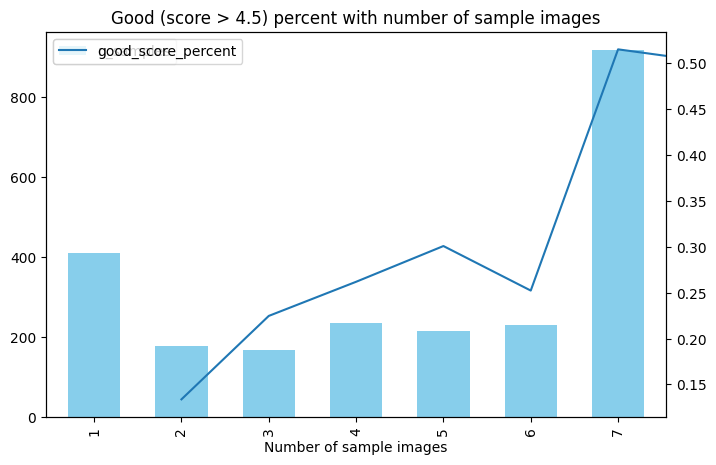

In [16]:
# Compute Spearman's correlation coefficient
tmp = df_amazon_product_info[['Score', 'CountAltImages']].dropna()
corr, p_value = spearmanr(tmp["Score"], tmp["CountAltImages"])

print(f"Spearman correlation coefficient: {corr:.4f}; P value: {p_value:.1e}")

df = df_amazon_product_info[df_amazon_product_info.NumRatings > 10].groupby("CountAltImages").agg(
    good_score_percent=("Score", lambda x: (x > 4.5).mean()), n_samples=("Score", "count"))
ax = df.plot(y='n_samples', kind="bar", color="skyblue", width=0.6, figsize=(8, 5),
             title="Good (score > 4.5) percent with number of sample images", xlabel="Number of sample images")
df.plot(y=['good_score_percent'], ax=ax.twinx())

In [4]:
df_amazon_food_reviews.pivot_table(index=['UserId'], values=['ProductId'], aggfunc='count').sort_values(
    "ProductId", ascending=False)

,ProductId
UserId,
A281NPSIMI1C2R,17
A1YUL9PCJR3JTY,16
A3OXHLG6DIBRW8,10
AXO4PQU0XG3TG,7
AQQLWCMRNDFGI,7
...,...
A2APZJZT4OAKBY,1
A2AQWKT6IZCXZ3,1
A2ARKTFI3SE722,1


In [86]:
p = df_amazon_food_reviews.pivot_table(index=['ProductId'], aggfunc='count')[["Summary"]]
p[p.Summary > 1]

,Summary
ProductId,
6641040,3
7310172001,19
7310172101,16
B00002N8SM,3
B00004CI84,23
...,...
B000GZY8FC,4
B000GZY8W0,2
B000GZY942,2


In [6]:
df_amazon_product_info = df_amazon_product_info[
    df_amazon_product_info.category.apply(lambda x: sum(['food' in e.lower() for e in x])) > 0]


<Axes: xlabel='Score', ylabel='ScorePolarizationIndex'>

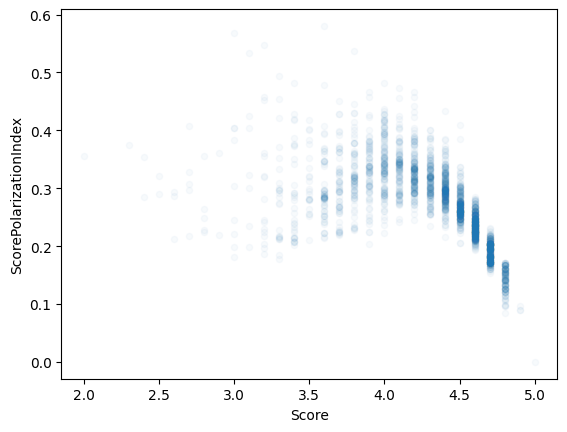

In [248]:
df_amazon_product_info[df_amazon_product_info.NumRatings > 20].plot.scatter(x='Score', y='ScorePolarizationIndex',
                                                                            alpha=0.03)

<Axes: >

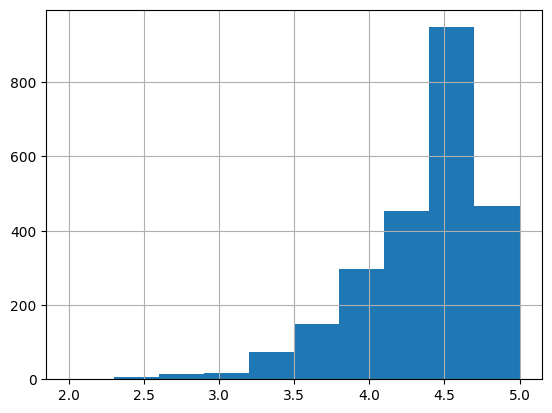

In [255]:
df_amazon_product_info[df_amazon_product_info.NumRatings > 20].Score.hist(bins=10)